Este agarra los audio segments de audio_segments/, los procesa, y carga los spectrograms finales a specs/ como archivos .npy

In [2]:
import os, sys
import pandas as pd
import numpy as np
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import create_single_spectrogram_npy, save_test_audio, plot_summary, load_audio_segments_from_disk, clean_dir

In [3]:
def create_spectrograms_from_segments_npy(segments, spectrogram_dir, output_csv_path, 
                                        test_audios_dir=None, mels=224, hoplen=512, 
                                        nfft=2048, noise_reduce=False):
    """
    Create spectrograms from extracted audio segments and save as .npy files.
    
    Args:
        segments (list): List of segment dictionaries from extract_audio_segments
        spectrogram_dir (str): Directory to save spectrogram .npy files
        output_csv_path (str): Path to save the output CSV
        test_audios_dir (str, optional): Directory to save test audio samples
        mels (int): Number of mel bands for spectrogram
        hoplen (int): Hop length for spectrogram
        nfft (int): FFT window size
        noise_reduce (bool): Whether to apply noise reduction
        
    Returns:
        pd.DataFrame: DataFrame with spectrogram metadata
    """
    print(f"Creating spectrograms from {len(segments)} segments...")
    
    os.makedirs(spectrogram_dir, exist_ok=True)
    if test_audios_dir:
        os.makedirs(test_audios_dir, exist_ok=True)
    
    spectrogram_records = []
    saved_test_audios = 0
    skipped_count = 0
    
    for i, segment_info in enumerate(segments):
        # Apply noise reduction if requested
        if noise_reduce:
            segment_info['audio_data'] = reduce_noise_seg(
                segment_info['audio_data'], 
                srate=segment_info['sr'], 
                filename=segment_info['original_filename'], 
                class_id=segment_info['class_id']
            )
        
        # Create spectrogram as .npy file
        record = create_single_spectrogram_npy(segment_info, spectrogram_dir, mels, hoplen, nfft)
        
        if record is not None:
            # Save test audio if requested (first 10 only)
            if test_audios_dir and saved_test_audios < 10:
                save_test_audio(segment_info, test_audios_dir)
                saved_test_audios += 1
            
            spectrogram_records.append(record)
        else:
            skipped_count += 1
    
    # Create and save final DataFrame
    final_df = pd.DataFrame(spectrogram_records)
    final_df.to_csv(output_csv_path, index=False)
    
    # Print summary
    print(f"Spectrogram generation summary:")
    print(f"  Total processed: {len(segments)}")
    print(f"  Successfully created: {len(spectrogram_records)}")
    print(f"  Skipped due to errors: {skipped_count}")
    
    plot_summary(final_df, output_csv_path)
    return final_df

In [4]:
# Define Paths
# Input: Audio segments from AudioExtracting notebook
segments_dir = os.path.join('..', 'database', 'audio_segments')
segments_csv_path = os.path.join('..', 'database', 'meta', 'audio_segments.csv')

# Output: Spectrograms and metadata - using specs/ directory for .npy files
specs_dir = os.path.join('..', 'database', 'specs')
output_csv = os.path.join('..', 'database', 'meta', 'final_specs.csv')
test_audios_dir = os.path.join('..', 'database', 'test_audios')

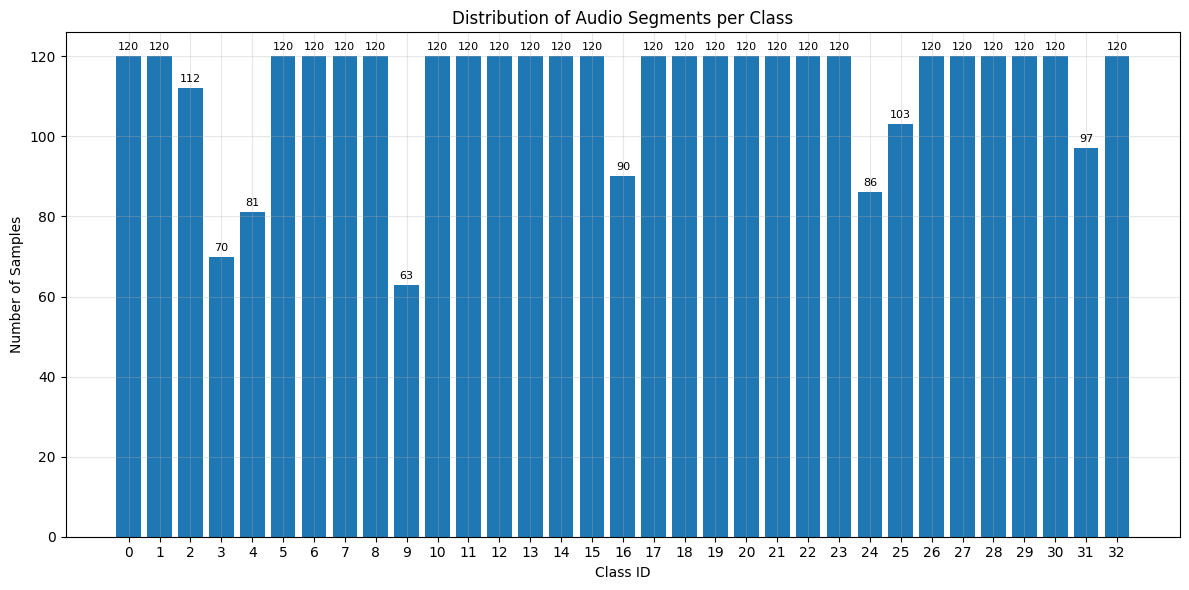

Total classes: 33
Total segments: 3702
Average segments per class: 112.2


In [5]:
# Load the segments CSV and plot distribution of samples per class
segments_df = pd.read_csv(segments_csv_path)

# Count samples per class
class_counts = segments_df['class_id'].value_counts().sort_index()

# Create the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Distribution of Audio Segments per Class')
plt.xticks(class_counts.index)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(class_counts.values):
    plt.text(class_counts.index[i], v + 1, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Total classes: {len(class_counts)}")
print(f"Total segments: {len(segments_df)}")
print(f"Average segments per class: {len(segments_df) / len(class_counts):.1f}")

In [6]:
# Preview files in segments_dir
print(f"Checking directory: {segments_dir}")
if os.path.exists(segments_dir):
    files = os.listdir(segments_dir)
    print(f"Total files in segments_dir: {len(files)}")
    print("\nFirst 10 files:")
    for file in files[:10]:
        print(f"  {file}")
    if len(files) > 10:
        print("  ...")
else:
    print("Directory does not exist!")

Checking directory: ..\database\audio_segments
Total files in segments_dir: 3702

First 10 files:
  XC112710_1582.wav
  XC112710_1583.wav
  XC112710_1584.wav
  XC112710_1585.wav
  XC112712_2862.wav
  XC112712_2863.wav
  XC112712_2864.wav
  XC112712_2865.wav
  XC112712_2866.wav
  XC112712_2867.wav
  ...


In [7]:
print("Loading audio segments from disk...")
segments = load_audio_segments_from_disk(segments_csv_path, segments_dir, sr=32000)

if not segments:
    print("No segments loaded! Make sure AudioExtracting notebook has been run first.")
else:
    print(f"Loaded {len(segments)} segments from disk")
    print(f"First segment keys: {list(segments[0].keys())}")

Loading audio segments from disk...
Loaded 3702 segments from disk
First segment keys: ['audio_data', 'class_id', 'author', 'original_filename', 'segment_index', 'sr']


Resetting ..\database\specs directory...
Resetting ..\database\test_audios directory...
Creating spectrograms from loaded segments as .npy files...
Creating spectrograms from 3702 segments...
Spectrogram generation summary:
  Total processed: 3702
  Successfully created: 3702
  Skipped due to errors: 0


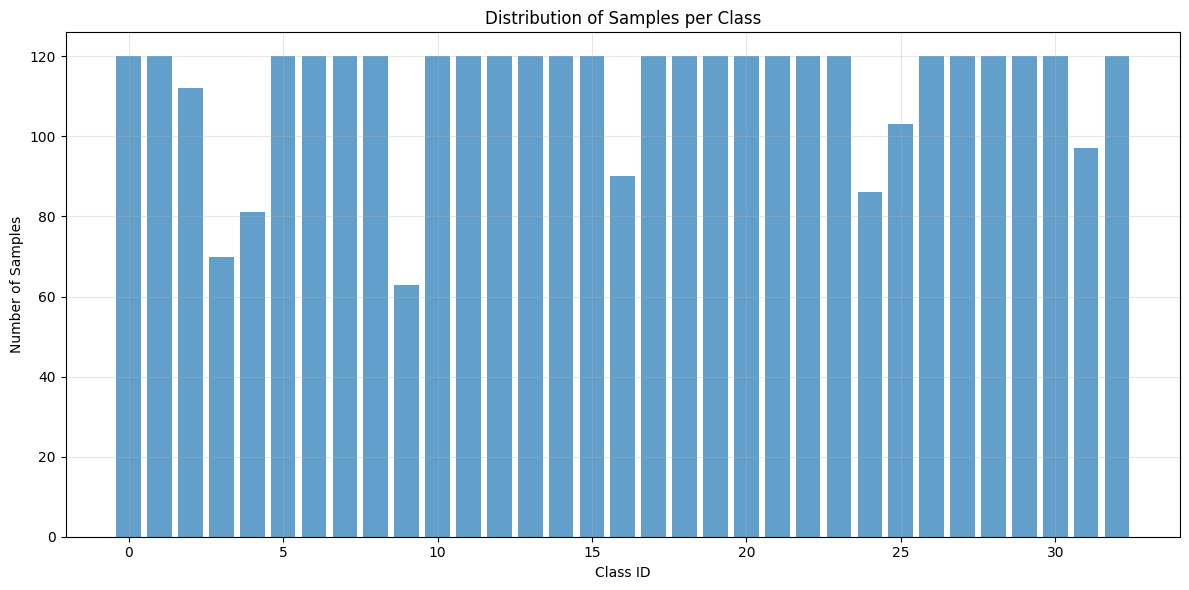

Spectrogram generation complete!


In [8]:
clean_dir(specs_dir)
clean_dir(test_audios_dir)

print("Creating spectrograms from loaded segments as .npy files...")
specs = create_spectrograms_from_segments_npy(
    segments, specs_dir, output_csv, 
    test_audios_dir=test_audios_dir, 
    mels=224, hoplen=512, nfft=2048, 
    noise_reduce=False
)

print("Spectrogram generation complete!")

Aca veo los tamaños de los archivos .npy

In [9]:
import random
amount = 20

# List all .npy files in specs_dir
spec_files = [f for f in os.listdir(specs_dir) if f.endswith('.npy')]

# Fetch random .npy files
random_files = random.sample(spec_files, min(amount, len(spec_files)))

for fname in random_files:
    spec_path = os.path.join(specs_dir, fname)
    spec_array = np.load(spec_path)
    print(f"{fname}: {spec_array.shape}, dtype: {spec_array.dtype}, range: [{spec_array.min():.3f}, {spec_array.max():.3f}]")

XC601401_958_958.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC124010_636_636.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC359333_889_889.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC476264_1327_1327.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC166050_3606_3606.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC457359_1304_1304.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC114493_1849_1849.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC511455_373_373.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC601401_957_957.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC325906_2391_2391.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC288823_427_427.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC32469_1699_1699.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC294699_2121_2121.npy: (224, 188), dtype: float32, range: [0.000, 1.000]
XC145933_777_777.npy: (224, 188), dtype: float32, r

In [10]:
# Test SpecAugment on generated spectrograms (.npy format)
from utils.specaugment import SpecAugment, get_recommended_params, visualize_specaugment, test_specaugment_on_random_spec

num_specs = len(spec_files)
print(f"Total spectrograms available: {num_specs}")

num_classes = len(class_counts)
print(f"Total classes available: {num_classes}")

samples_per_class = num_specs / num_classes
print(f"Average samples per class: {samples_per_class:.1f}")

# Get recommended parameters for your dataset
recommended_params = get_recommended_params(
    num_samples=num_specs,
    num_classes=num_classes,
    input_size=(224, 313)  # height, width
)

print("Recommended SpecAugment parameters for your dataset:")
for key, value in recommended_params.items():
    print(f"  {key}: {value}")

Total spectrograms available: 3702
Total classes available: 33
Average samples per class: 112.2
Recommended SpecAugment parameters for your dataset:
  time_mask_param: 50
  freq_mask_param: 18
  num_time_masks: 2
  num_freq_masks: 1
  mask_value: 0.0
  p: 0.9


Testing SpecAugment on random spectrogram...


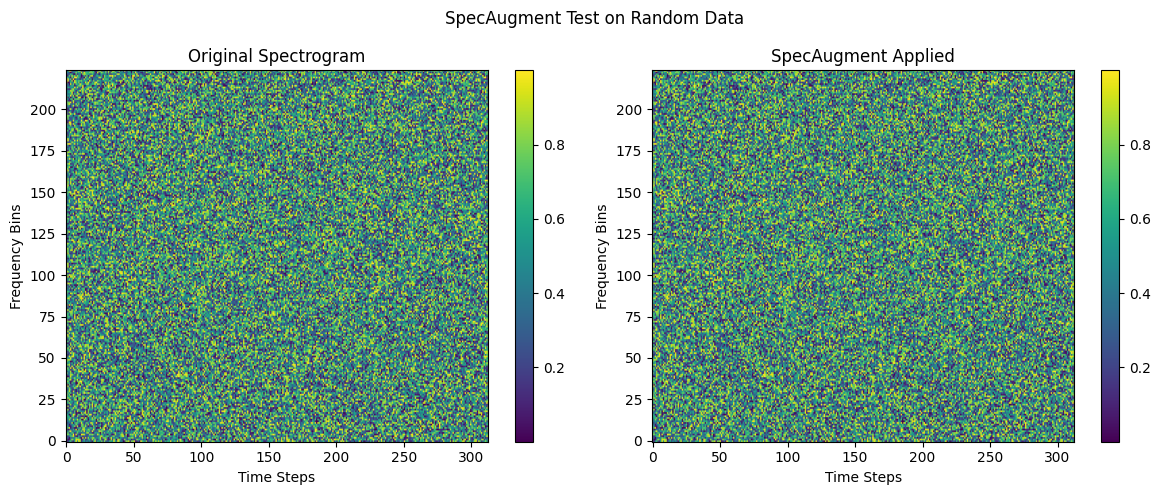

(tensor([[0.2130, 0.1063, 0.5354,  ..., 0.8216, 0.6099, 0.0499],
         [0.4681, 0.0172, 0.0494,  ..., 0.5970, 0.3303, 0.5708],
         [0.3087, 0.2840, 0.0088,  ..., 0.1000, 0.2089, 0.1500],
         ...,
         [0.1086, 0.2509, 0.2944,  ..., 0.6256, 0.6590, 0.1880],
         [0.5033, 0.4466, 0.1840,  ..., 0.8468, 0.5154, 0.9775],
         [0.0219, 0.5344, 0.9241,  ..., 0.4141, 0.6211, 0.6573]]),
 tensor([[0.2130, 0.1063, 0.5354,  ..., 0.8216, 0.6099, 0.0499],
         [0.4681, 0.0172, 0.0494,  ..., 0.5970, 0.3303, 0.5708],
         [0.3087, 0.2840, 0.0088,  ..., 0.1000, 0.2089, 0.1500],
         ...,
         [0.1086, 0.2509, 0.2944,  ..., 0.6256, 0.6590, 0.1880],
         [0.5033, 0.4466, 0.1840,  ..., 0.8468, 0.5154, 0.9775],
         [0.0219, 0.5344, 0.9241,  ..., 0.4141, 0.6211, 0.6573]]))

In [11]:
# Test SpecAugment on a random spectrogram
print("Testing SpecAugment on random spectrogram...")
test_specaugment_on_random_spec(shape=(224, 313), **recommended_params)


Testing SpecAugment on actual spectrograms...

Testing on XC112710_1582_1582.npy


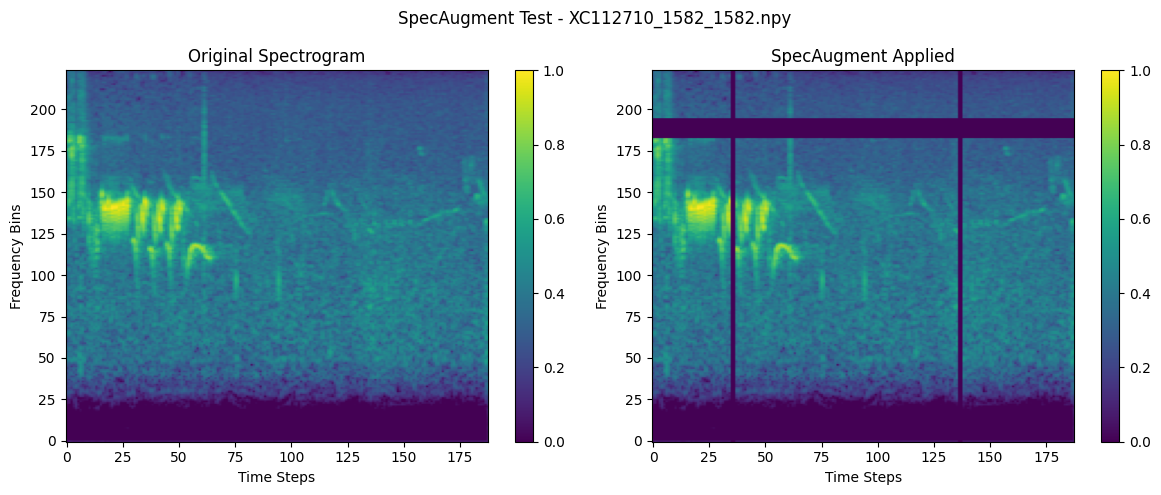


Testing on XC112710_1583_1583.npy


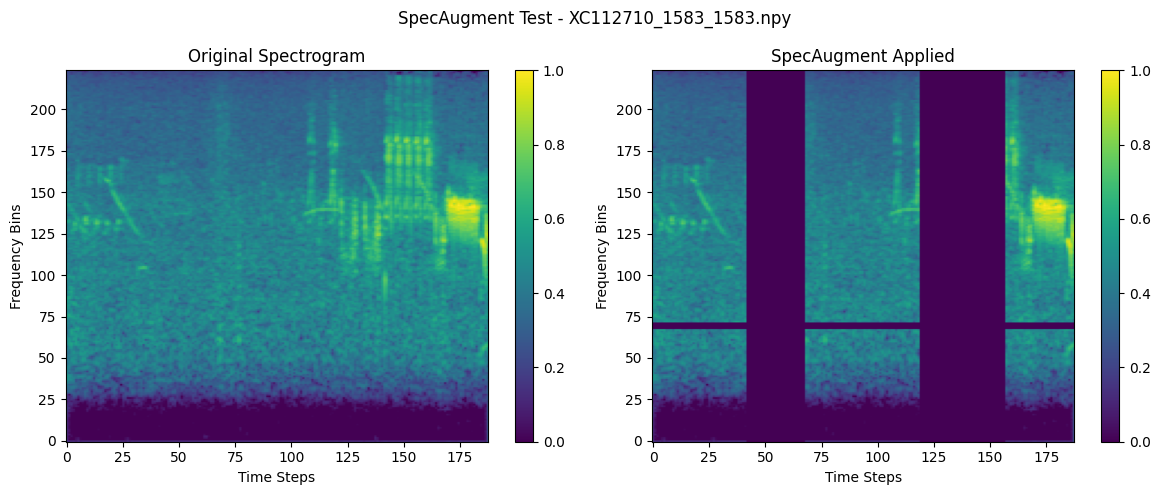


Testing on XC112710_1584_1584.npy


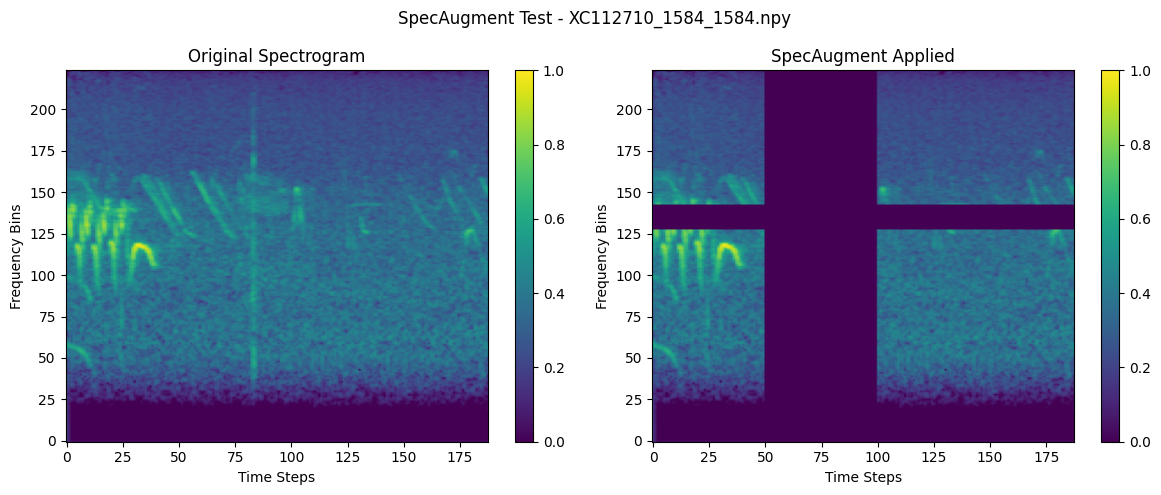

In [12]:
# Test SpecAugment on actual generated spectrograms (.npy format)
if len(specs) > 0:
    print(f"\nTesting SpecAugment on actual spectrograms...")
    
    # Load a few actual spectrograms for testing
    test_files = [f for f in os.listdir(specs_dir) if f.endswith('.npy')][:3]
    
    for i, filename in enumerate(test_files):
        print(f"\nTesting on {filename}")
        
        # Load spectrogram from .npy file
        spec_path = os.path.join(specs_dir, filename)
        spec_array = np.load(spec_path)  # Already normalized to 0-1
        spec_tensor = torch.tensor(spec_array, dtype=torch.float32)
        
        # Apply SpecAugment
        augmenter = SpecAugment(**recommended_params)
        augmented_spec = augmenter(spec_tensor)
        
        # Visualize
        visualize_specaugment(
            spec_tensor, 
            augmented_spec, 
            title=f"SpecAugment Test - {filename}"
        )
        
        if i >= 2:  # Limit to 3 examples
            break
else:
    print("No spectrograms available for testing. Run spectrogram generation first.")